# HallThruster.jl Tutorial

HallThruster is an efficient 1D fluid model to simulate Hall Thruster discharges. 
This tutorial will show you how to get started with HallThruster.jl and will compare our results to the Landmark study. Detailed information can be found in the [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/).

First install HallThruster.jl according to the Readme instructions. Then load it:

In [1]:
using HallThruster

Let's also load Plots for visualization:

In [2]:
using Plots

# Landmark comparisons

Let's try and replicate the LANDMARK benchmarks. 

Let us define the function `run_landmark()` as a helper function. The most important arguments are `duration; ncells, nsave, dt`. When increasing the amount of cells, the timestep has to be reduced accordingly to satisfy the CFL condition. `nsave` specifies the amount of times the solution is saved in constant time intervals. 

Here we have the Landmark source terms and energy loss terms given as a standard, and we can select one of the 3 test cases to run. We initialize a new simulation and define the domain as twice the thruster length, as evident by the argument `domain = (0.0, 0.05)`. The default flux is set to `rusanov` and the time marching algorithm from DifferentialEquations.jl for the heavy species is a strong stability preserving Runge Kutta scheme of second order `SSPRK22`. 

In [3]:
function run_landmark(duration = 0.0002; ncells = 100, nsave = 2, dt = 1e-8, case = 1)

    domain = (0.0, 0.05)

    #Landmark cases loss frequencies
    αϵ_in, αϵ_out = if case == 1
        (1.0, 1.0)
    elseif case == 2
        (0.5, 1.0)
    elseif case == 3
        (0.4, 1.0)
    end

    scheme = HallThruster.HyperbolicScheme(flux_function = HallThruster.rusanov, limiter = HallThruster.no_limiter, reconstruct = false, WENO = false)

    ϵ_anode = 3.0
    ϵ_cathode = 3.0

    # Define the length over which the anomalous transport, wall collision frequency, and wall loss coefficients change
    transition_function = HallThruster.LinearTransition(1e-3, 0.0)

    config = HallThruster.Config(;
        ncharge = 1,
        anode_Te = 2/3 * ϵ_anode,
        cathode_Te = 2/3 * ϵ_cathode,
        discharge_voltage = 300.0,
        ionization_model = HallThruster.LandmarkIonizationLookup(),
        excitation_model = HallThruster.LandmarkExcitationLookup(),
        electron_neutral_model = HallThruster.LandmarkElectronNeutral(),
        electron_ion_collisions = false,
        wall_loss_model = HallThruster.ConstantSheathPotential(-20, αϵ_in, αϵ_out),
        wall_collision_freq = 1.0 * 1e7,
        LANDMARK = true,
        neutral_velocity = 150.0,
        neutral_temperature = 0.0,
        ion_temperature = 0.0,
        thruster = HallThruster.SPT_100,
        anode_mass_flow_rate = 5e-6,
        scheme,
        domain,
        transition_function,
    )

    @time sol = HallThruster.run_simulation(config; dt, duration, ncells, nsave)
    return sol
end

run_landmark (generic function with 2 methods)

Now we can use `run_landmark()` to perform simulations. Running a millisecond with 200 cells takes 15 to 30 seconds.

In [4]:
sol = run_landmark(1e-3; ncells=200, nsave=10000, case = 1, dt = 0.9e-8)

 26.141233 seconds (10.89 M allocations: 932.540 MiB, 1.37% gc time, 33.73% compilation time)


Hall thruster solution with 10000 saved frames
Retcode: Success
End time: 0.001 seconds

`sol` is a `Solution` object. This mimics a standard DifferentialEquations `ODESolution` object and has the following fields
- `t`: The times at which the solution was saved
- `u`: A vector of solution matrices of length `nsave`. This contains the main state variables: $\rho_n$, $\rho_i$, $\rho_i u_i$, and $n_e\epsilon$
- `savevals`: A vector of NamedTuples containing some auxilliary variables including $\phi$, $n_e$, $Tev$, $\nu_{AN}$ , $\nu_{en}$, $\nu_{ei}$, and $\mu$
- `retcode`: A short symbol describing how the solution ended. Generally this should be `:success`.
- `destats`: Some DifferentialEquations.jl solver statistics
- `params`: The params that the simulation was run with.

HallThruster has some built-in plotting and postprocessing faculties. Firstly, we can type `plot(sol, frame; case)` To plot the solution at the given frame (from 1 to nsave) and (optionally) compare to the LANDMARK benchmarks.

In [18]:
plot(sol; case = 1)

UndefVarError: UndefVarError: Plots not defined

This doesn't look too similar to the benchmark. However, Hall thrusters are strongly oscillatory devices, and we only plotted the last frame. Let's look instead at the time averaged behavior. For this, we use `plot_timeaveraged(sol, starting_frame, case)`, where `starting_frame` is the frame at which we start the averaging.

In [6]:
HallThruster.plot_timeaveraged(sol, 1; case=1)

UndefVarError: UndefVarError: Plots not defined

This looks better. We can also check the other LANDMARK cases: Below is the time-averaged behavior of case 2:

In [7]:
sol_case2 = run_landmark(1e-3; ncells=200, nsave=10000, case = 2, dt = 0.6e-8);
HallThruster.plot_timeaveraged(sol_case2, 1; case=2)

UndefVarError: UndefVarError: Plots not defined

And case 3: 

In [8]:
sol_case3 = run_landmark(1e-3; ncells=200, nsave=1000, case = 3, dt = 0.6e-8);
HallThruster.plot_timeaveraged(sol_case3, 1; case=3)

UndefVarError: UndefVarError: Plots not defined

## Built-in postprocessing tools

Here we will show how to extract thrust, current and other useful quantities from a simulation. 
We can calculate the discharge current by giving a `Solution` as an argument. The current is computed at the cathode if no other argument is given, to compute it at the anode type `compute_current(sol, "anode")`. 
The resulting Matrix is of columns `nsave` and stores the ion current in `[1, :]`, electron current in `[2, :]`, and total current in `[3, :]`. 
We can plot the current by calling `plot_current(curret, sol, "title")`. 

In [9]:
current = HallThruster.compute_current(sol)
HallThruster.plot_current(current, sol, "Current at cathode")

UndefVarError: UndefVarError: Plots not defined

In [10]:
current_case2 = HallThruster.compute_current(sol_case2)
HallThruster.plot_current_compare([current, current_case2], [sol, sol_case2], ["Case 1", "Case 2"])

UndefVarError: UndefVarError: Plots not defined

We have compared the total discharge currents from case 1 and 2. `plot_current_compare()` can take more than two currents as well. 
Next, let us extract the thrust as a function of time.

 26.526493 seconds (222.51 k allocations: 317.684 MiB, 0.57% gc time)
 25.930646 seconds (42.50 k allocations: 32.295 MiB)


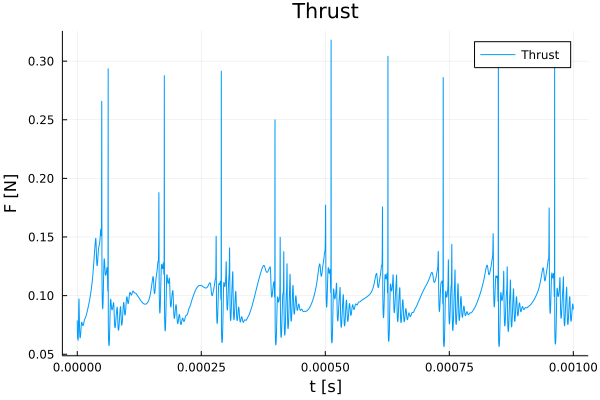

In [11]:
thrust = HallThruster.compute_thrust(sol)
HallThruster.plot_thrust(thrust, sol)

As with the currents, we can compare as many thrusts as we want. 

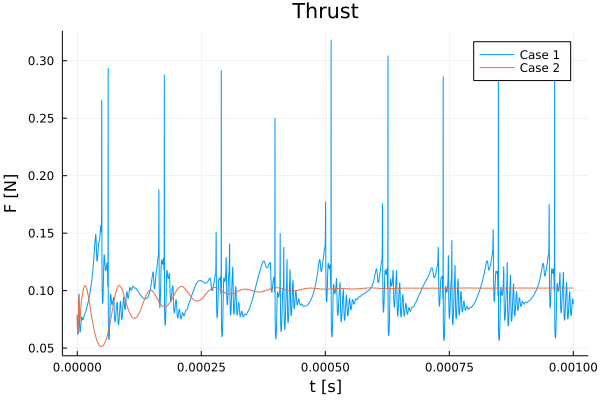

In [12]:
thrust_case2 = HallThruster.compute_thrust(sol_case2)
HallThruster.plot_thrust_compare([thrust, thrust_case2], [sol, sol_case2], ["Case 1", "Case 2"])

## Extracting data from the `Solution` object

et us take a closer look at the `Solution` object and how to extract data. Here we show how to access data in the state vector `sol.u`. To access the neutral density at the last timestep and the z position of the corresponding values we would type

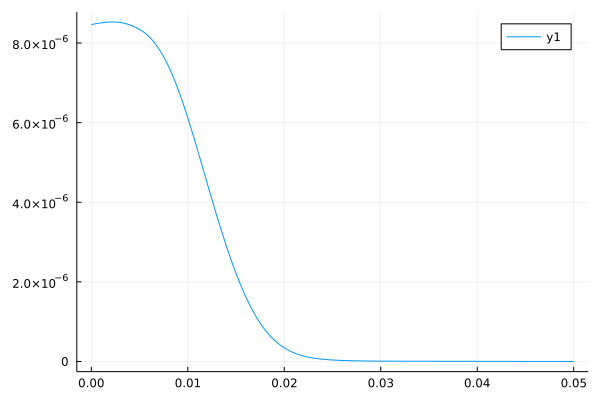

In [13]:
nn_end = sol.u[end][1, :]
z = sol.params.z_cell
plot(z, nn_end)

Similarly, we can access data in the stored in `sol.savevals`. Let us extract the potential profile at the last timestep and plot it vs position. 

In [14]:
ϕ_end = sol.savevals[end].ϕ


201-element Vector{Float64}:
 300.0
 300.57870576969873
 300.6977400853754
 300.82638206895365
 300.96500136638053
 301.1084903154136
 301.25257800670244
 301.3947344644649
 301.53398965751927
 301.6696203587758
   ⋮
  11.022797373784956
   9.85784445638506
   8.669919891051844
   7.452275383720805
   6.1954657632652745
   4.885497195316856
   3.5003723075579067
   2.0018026848991766
   0.0

Oops this `Vector` is only of `length` 201, which is a result of the staggered grid. We should use the version $\phi_{cell}$ with the potential values interpolated to cell centers when plotting against the axial position given in `sol.params.z_cell`. 

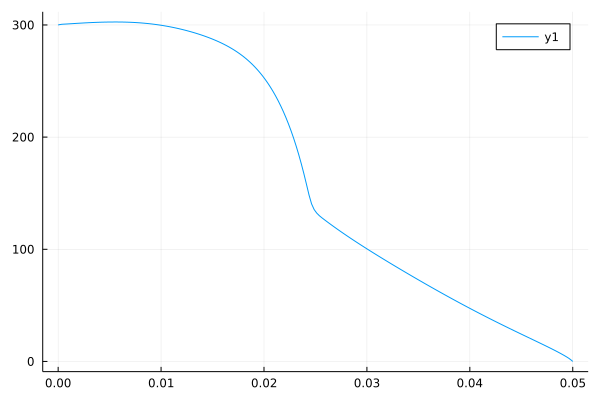

In [15]:
ϕ_end = sol.savevals[end].ϕ_cell
plot(z, ϕ_end)

The totality of fields available in `sol.savevals[frame]` is the following `(; μ, Tev, ϕ, ∇ϕ, ne, pe, ue, ∇pe, νan, νc, νen, νei, νw, ϕ_cell)`.

We can also inspect parameters that the simulation was run with and do not change over time. These are accesssible in `sol.params`. 
The totality of parameters accesible are the following 

        ```julia
        config, 
        ϕ_L,
        ϕ_R,
        Te_L, 
        Te_R,
        L_ch,
        A_ch,
        z_cell,
        z_edge,
        dt,
        progress_bar,
        index, cache, fluids, fluid_ranges, species_range_dict,
        iteration,
        ionization_reactions,
        ionization_reactant_indices,
        ionization_product_indices,
        excitation_reactions,
        excitation_reactant_indices,
        electron_neutral_collisions
        ```

Where `config` contains even more parameters and settings. You are referred to the [Configuration](https://um-pepl.github.io/HallThruster.jl/dev/config/) page of the documentation for a detailed description. 
As an example, let us extract the anomalous collision frequency model from the Landmark case 1 simulation. 



In [16]:
anom_model = sol.params.config.anom_model

HallThruster.TwoZoneBohm((0.00625, 0.0625))

This returns a `TwoZoneBohm` object, which defines the anomalous collision frequency used in the Landmark cases. Anomalous collision frequency models in HallThruster.jl are explained [here](https://um-pepl.github.io/HallThruster.jl/dev/anomalous_transport/).

Let us plot the anomalous collision frequency vs axial position. 

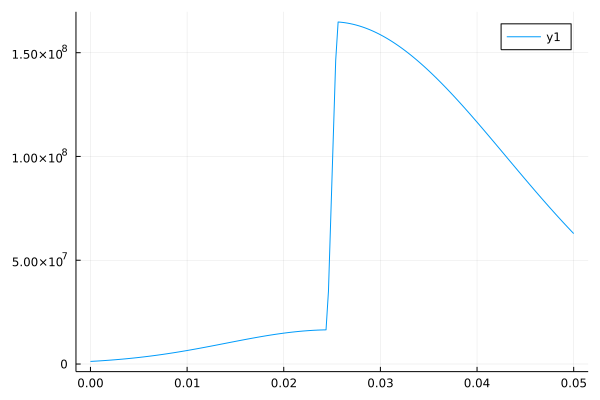

In [17]:
plot(z, [anom_model(sol.u[end], sol.params, i) for i in 1:length(z)])

If you want to use other numerical fluxes, change the physics through collisions, boundary conditions, wall sheath losses, define new thrusters and change the domain length, use another propellant or provide your own source terms and ionization models, check out the Configuration section of the official [Documentation](https://um-pepl.github.io/HallThruster.jl/dev/.)